In [ ]:
"""
+ imports
+ set random seed
+ set paths to dfs
+ set target_name

+ head train test
+ df info
+ df describe numeric / category
+ duplicates / constants
+ factorize columns for EDA purposes
+ nans: !IterativeImputer, Regressor! CATBOOSTREGERESSOR on RAW (temporal target feature) - try both and compare distribution plots and describe
or just DROP 310 nans
+ outliers: +IsolationForest, boxplots, scatterplots, IQR, removing: IQR, median/std, OR just DROP 7 elements
+ distribution / log distribution, PowerTransformer (try with base model)
countplots
show statistical distribution several features: plots with target, shapiro, mannwhitney, conf.intervals
+ target normalized counts
+ feature value_counts
+ make prediction on raw data with logreg: all features factorize only, fillna median / drop outliers and predict again

+add metrics function
+report
+vote
+cross_validation
+calibration probas

+XGBoost importancies
mutual or other statistical importancies
correlation matrix
shap after data split
choosebestsubset (plot with annotation instead of star and line)

class preprocessor
if correlation between features use AutoEncoder with keras to reduce dims (t-SNE), see new features distribution
+ DO NOT! apply normal distribution for numeric features, optionaly
category: binary encoding for objects, except Class = WoE (not for catboost: define one_hot_max_size 2 or 5)
set user_id as index for further predict_proba for every customer with best model
check feature dtypes
DROP 7 outliers 310 nans or predict nans and IQR outliers

new features
kmeans clustering with elbow method, silhuete_score (without target)
look for logical ones
isNan, isSusp (for possible outliers) - NO - too sparse
np.abs(Arrival - Departure) if Arrival and Departure are high correlated

data split
learning curve for best split

use MinMaxScaler if data has no normal distribution, otherwise StandardScaler (RobustScaler if outliers left)
in model use balanced param (Over, Under, SMOTE, SMOTETomek not needed: not such disbalanced), class_weight higher? 
base model: LogisticRegression
lightGBM (see churn params), also add callback in fit method to dynamicaly reduce lr
catboost: two types - all one_hot / one_hot for small and random mean target encoding for many cats / CALLBACKS
rewise with calibration probas
"""

In [ ]:
!pip install catboost shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import learning_curve
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
import lightgbm
from scipy.stats import mannwhitneyu, shapiro, probplot
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import shap
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
train_root = r'/content/drive/My Drive/data/flight/train.csv'
test_root = r'/content/drive/My Drive/data/flight/test.csv'
TARGET_NAME = 'satisfaction'

In [ ]:
train = pd.read_csv(train_root, index_col=0)
test = pd.read_csv(test_root, index_col=0)
train.set_index('id', drop=True, inplace=True)
test.set_index('id', drop=True, inplace=True)

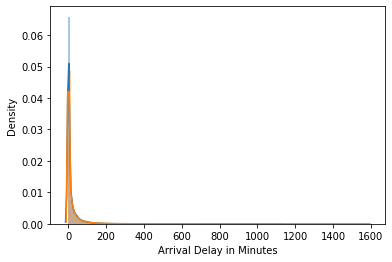

In [ ]:
sns.distplot(test['Arrival Delay in Minutes'], bins=100)
sns.distplot(train['Arrival Delay in Minutes'], bins=100)
plt.show()

In [ ]:
train.head(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,,,
70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied


In [ ]:
test.tail(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,,,
90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,satisfied
34799,Female,Loyal Customer,42,Personal Travel,Eco,264,2,5,2,5,4,2,2,1,1,2,1,1,1,1,0,0.0,neutral or dissatisfied


In [ ]:
train.info()
# test.info() # same
# Nans in Arrival Delay in Minutes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 70172 to 62567
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1

In [ ]:
train.describe()
# Departure Delay in minutes / Arrival Delay in minutes seem to have outliers
# int datatypes, Age is close to normal distribution
# Flight Distance not normal

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [ ]:
train.describe(include=[np.object])

,Gender,Customer Type,Type of Travel,Class,satisfaction
count,103904,103904,103904,103904,103904
unique,2,2,2,3,2
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,52727,84923,71655,49665,58879


In [ ]:
train.duplicated().astype(np.int).sum(), test.duplicated().astype(np.int).sum()
# also no constant features

(0, 0)

In [ ]:
train[TARGET_NAME].value_counts(normalize=True)
# (Over, Under, SMOTE, SMOTETomek not needed: not such disbalanced) - use class_weight parameter
# do not forget pipeline for cross-validation

neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: satisfaction, dtype: float64

In [ ]:
for idx, col in enumerate(train.columns[:-1]):
    print(train[col].value_counts())
    print('#'*40)
# small category of '0' rate in int columns, can be interpreted as outliers, but there are such customers

Female    52727
Male      51177
Name: Gender, dtype: int64
########################################
Loyal Customer       84923
disloyal Customer    18981
Name: Customer Type, dtype: int64
########################################
39    2969
25    2798
40    2574
44    2482
42    2457
      ... 
74      47
76      45
79      42
78      33
85      17
Name: Age, Length: 75, dtype: int64
########################################
Business travel    71655
Personal Travel    32249
Name: Type of Travel, dtype: int64
########################################
Business    49665
Eco         46745
Eco Plus     7494
Name: Class, dtype: int64
########################################
337     660
594     395
404     392
2475    369
862     369
       ... 
1466      1
856       1
810       1
1361      1
3763      1
Name: Flight Distance, Length: 3802, dtype: int64
########################################
3    25868
2    25830
4    19794
1    17840
5    11469
0     3103
Name: Inflight wifi service, dtype: i

In [ ]:
train[train['Checkin service'] == 0]  # set to 1
train[train['Gate location'] == 0]  # set to 1
train[train['Seat comfort'] == 0]  # set to 1
train[train['Inflight service'] == 0]
train[train['Cleanliness'] == 0] 
# it is not abs bad not to union such values with more common, if we use them as numeric
# but for catboost it is not good, unless one_hot_max_size < 5
# as if we will try both <5 and == 5 so apply no transformation

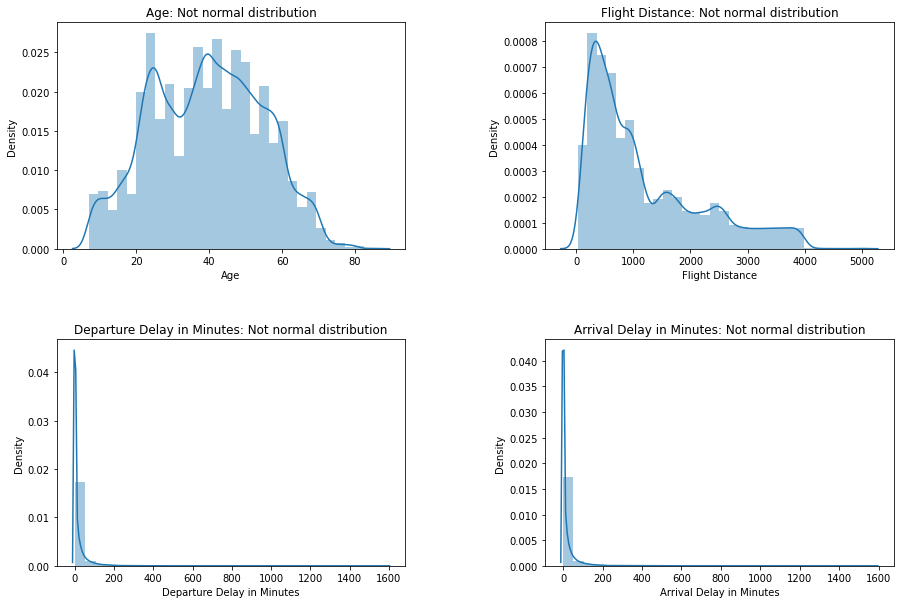

In [ ]:
plt.figure(figsize=(15, 10))
numeric_cols = train[['Age', 'Flight Distance', 
                      'Departure Delay in Minutes', 
                      'Arrival Delay in Minutes']] #.select_dtypes(['float']).columns
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 2, idx + 1)
    dist = 'Normal Distribution' if shapiro(train[col].dropna())[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{col}: {dist}')
    sns.distplot(train[col], bins=30)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# obviously there is no normal distribution

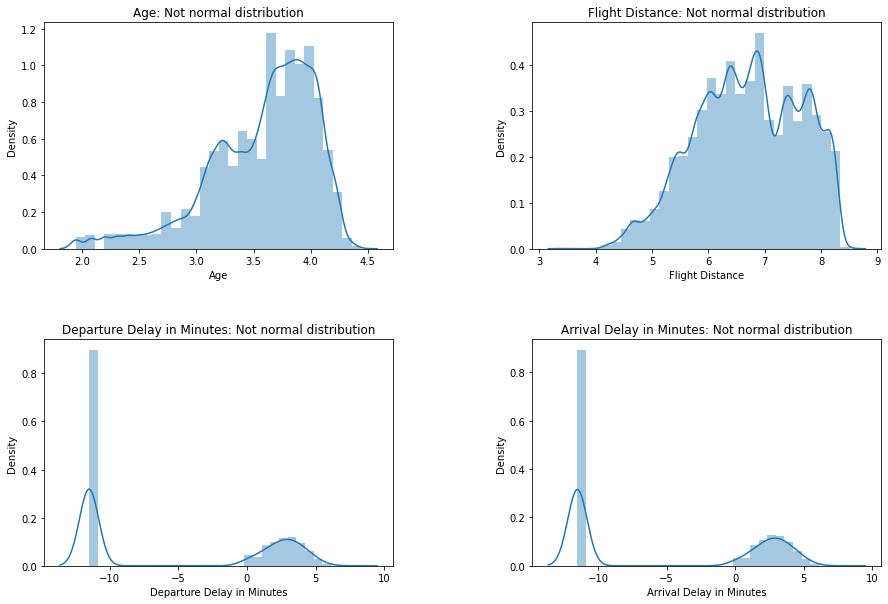

In [ ]:
plt.figure(figsize=(15, 10))
numeric_cols = train[['Age', 'Flight Distance', 
                      'Departure Delay in Minutes', 
                      'Arrival Delay in Minutes']] 
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 2, idx + 1)
    value = np.log(train[col].dropna() + 1e-5)
    dist = 'Normal Distribution' if shapiro(value)[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{col}: {dist}')
    sns.distplot(value, bins=30)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# obviously there is no normal distribution, applying np.log is useless

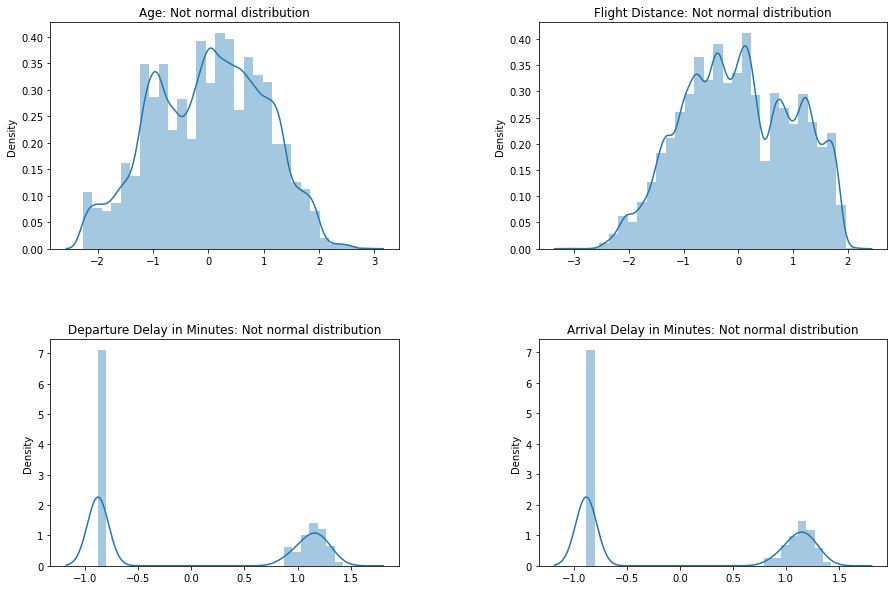

In [ ]:
power = PowerTransformer(method='box-cox')
plt.figure(figsize=(15, 10))
numeric_cols = train[['Age', 'Flight Distance', 
                      'Departure Delay in Minutes', 
                      'Arrival Delay in Minutes']] 
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 2, idx + 1)
    value = power.fit_transform((train[col].dropna() + 1e-5).values.reshape(-1,1))
    dist = 'Normal Distribution' if shapiro(value.squeeze())[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{col}: {dist}')
    sns.distplot(value, bins=30)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# obviously there is no normal distribution, applying PowerTranformer is not nessasary

In [ ]:
#train[TARGET_NAME].factorize()[0].astype(np.uint8)
for column in train.select_dtypes(['object']).columns: # object before catboost
    if len(train[column].unique()) < 3:
        train[column] = train[column].factorize()[0].astype(np.uint8)
for column in test.select_dtypes(['object']).columns: # object before catboost
    if len(test[column].unique()) < 3:
        test[column] = test[column].factorize()[0].astype(np.uint8)

In [ ]:
# Weight of Evidence for Class feature
vocab = {}
emb_count_0 = train.loc[train[TARGET_NAME] == 0, 'Class'].count()
emb_count_1 = train.loc[train[TARGET_NAME] == 1, 'Class'].count()
for item in train.Class.unique():
    percent_non_event = train.loc[((train[TARGET_NAME] == 0) & (train.Class == item)), 'Class'].count() / emb_count_0
    percent_event = train.loc[((train[TARGET_NAME] == 1) & (train.Class == item)), 'Class'].count() / emb_count_1
    vocab[item] = np.log(percent_non_event / percent_event)
train.Class = train.Class.map(vocab)
test.Class = test.Class.map(vocab)

In [ ]:
vocab

{'Business': -1.0883379468165046,
 'Eco': 1.2070388235175273,
 'Eco Plus': 0.8514518205052232}

In [ ]:
train.head(2)
# satisfied = 1, neutral or dissatisfied = 0

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,,,
70172,0,0,13,0,0.851452,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
5047,0,1,25,1,-1.088338,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0


In [ ]:
train.Class.unique()

array([ 0.85145182, -1.08833795,  1.20703882])

In [ ]:
q3 = np.quantile(train['Arrival Delay in Minutes'].dropna(), 0.75)
q1 = np.quantile(train['Arrival Delay in Minutes'].dropna(), 0.25)
q3 + 1.5 * (q3 - q1) # 32.5 
np.quantile(train['Arrival Delay in Minutes'].dropna(), 0.99)

184.0

In [ ]:
# outliers: subtract by 10 or IQR
train[train['Arrival Delay in Minutes'] > 700]

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,,,
69661,0,0,32,1,-1.088338,2916,2,2,2,2,5,5,5,3,4,5,4,5,3,5,1305,1280.0,1
69504,0,0,27,1,-1.088338,1746,1,1,4,1,4,5,5,4,3,5,4,5,4,5,859,860.0,1
5173,1,0,42,0,-1.088338,351,2,3,2,2,2,3,3,1,3,3,2,3,3,3,692,702.0,0
78292,0,0,23,1,1.207039,998,5,2,2,2,5,5,5,1,1,2,4,5,1,5,750,729.0,1
89638,0,0,29,1,-1.088338,944,2,5,5,5,2,2,2,2,4,3,3,2,4,2,729,717.0,0
79912,0,0,15,1,-1.088338,3979,2,2,2,2,2,2,2,2,2,4,3,2,3,2,853,823.0,0
4376,1,0,53,1,-1.088338,2418,3,4,4,4,3,3,3,3,5,2,2,3,4,3,930,952.0,0
4903,0,0,49,1,-1.088338,1959,1,1,1,1,4,4,4,4,4,4,5,4,4,4,1017,1011.0,1
83676,0,1,43,1,-1.088338,577,3,3,3,2,3,5,5,5,4,5,5,5,3,5,921,924.0,0


In [ ]:
train['isnan'] = 0
train.loc[~train['Arrival Delay in Minutes'].isna(), 'isnan'] = 1

In [ ]:
# we have to predict only values in one columns, better not using IterativeImputer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
"""
boost = XGBRegressor(max_depth=5, learning_rate=0.05, n_estimators=300, objective='reg:squarederror', 
                       gamma=0, subsample=1., colsample_bytree=1., reg_lambda=1e-5, random_state=1)
boost.fit(X_train, y_train)
preds_train = boost.predict(X_train)
preds_test = boost.predict(X_test)
print(f'train MSE: {mean_squared_error(y_train, preds_train)}, train MAE: {mean_absolute_error(y_train, preds_train)}',
      f'train R^2: {r2_score(y_train, preds_train)}')
print(f'test MSE: {mean_squared_error(y_test, preds_test)}, test MAE: {mean_absolute_error(y_test, preds_test)}',
      f'test R^2: {r2_score(y_test, preds_test)}')
"""

train MSE: 0.03301879018545151, train MAE: 0.09360701590776443 train R^2: 0.8655977571692547
test MSE: 0.03427775949239731, test MAE: 0.0951164960861206 test R^2: 0.8601587447546903


In [ ]:
# add targeted temporal feature
temp = train.groupby(['Gender', 'Class', 'Age'])['Arrival Delay in Minutes'].mean().reset_index()
temp = temp.rename(columns={'Arrival Delay in Minutes': 'temp'})
train = train.merge(temp, on=['Gender', 'Class', 'Age'], how='left')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103904 non-null  category
 1   Customer Type                      103904 non-null  category
 2   Age                                103904 non-null  float64 
 3   Type of Travel                     103904 non-null  category
 4   Class                              103904 non-null  category
 5   Flight Distance                    103904 non-null  float64 
 6   Inflight wifi service              103904 non-null  int64   
 7   Departure/Arrival time convenient  103904 non-null  int64   
 8   Ease of Online booking             103904 non-null  int64   
 9   Gate location                      103904 non-null  int64   
 10  Food and drink                     103904 non-null  int64   
 11  Online boarding           

In [ ]:
train.Age = train.Age.astype(np.float)
train['Departure Delay in Minutes'] = train['Departure Delay in Minutes'].astype(float)
train['Flight Distance'] = train['Flight Distance'].astype(np.float)
train[TARGET_NAME] = train[TARGET_NAME].factorize()[0].astype(np.uint8)
for col in train.select_dtypes('object').columns:
    train[col] = train[col].astype('category')
cat_cols = train.select_dtypes(['category', 'int']).columns[:-1].to_list()
X = train[train.isnan == 1].drop([TARGET_NAME, 'Arrival Delay in Minutes', 'isnan'], axis=1)
y = train[train.isnan == 1]['Arrival Delay in Minutes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols) 
params_model = {
    'eval_metric': 'R2',
    'silent': True,
    'one_hot_max_size': 5,
    'early_stopping_rounds': 10,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,
    'random_seed': 1
}

In [ ]:
catboost = CatBoostRegressor(**params_model)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=20, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9226295202
bestIteration = 65

0:	loss: 0.9226295	best: 0.9226295 (0)	total: 8.1s	remaining: 2m 33s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.923305061
bestIteration = 56

1:	loss: 0.9233051	best: 0.9233051 (1)	total: 17.1s	remaining: 2m 34s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9222325084
bestIteration = 91

2:	loss: 0.9222325	best: 0.9233051 (1)	total: 33s	remaining: 3m 6s

bestTest = 0.9231752308
bestIteration = 399

3:	loss: 0.9231752	best: 0.9233051 (1)	total: 1m 44s	remaining: 6m 57s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9250336225
bestIteration = 250

4:	loss: 0.9250336	best: 0.9250336 (4)	total: 3m 2s	remaining: 9m 8s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9239928027
bestIteration = 83

5:	loss: 0.9239928	best: 0.9250336 (4)	total: 3m 14s	remaining: 7m 34s
Stopped by overfitting detector  (10 itera


bestTest = 0.9080330248
bestIteration = 86

Training on fold [1/5]



bestTest = 0.9312719463
bestIteration = 16

Training on fold [2/5]



bestTest = 0.9114868756
bestIteration = 56

Training on fold [3/5]



bestTest = 0.9024719471
bestIteration = 11

Training on fold [4/5]



bestTest = 0.8927933942
bestIteration = 11



In [ ]:
gs['params']

{'bagging_temperature': 1,
 'depth': 7,
 'iterations': 400,
 'l2_leaf_reg': 2.5,
 'learning_rate': 0.3,
 'subsample': 0.9}

In [ ]:
# try catboostRegressor on raw: without any encoding, UNION rare cats 
catboost = CatBoostRegressor(**params_model, depth=7, iterations=400, learning_rate=0.3, l2_leaf_reg=2.5, 
                             bagging_temperature=1., subsample=.9)
catboost.fit(train_pool, eval_set=test_pool, use_best_model=True)
preds_train = catboost.predict(X_train)
preds_test = catboost.predict(X_test)
print(f'train MSE: {mean_squared_error(y_train, preds_train)}, train MAE: {mean_absolute_error(y_train, preds_train)}',
      f'train R^2: {r2_score(y_train, preds_train)}')
print(f'test MSE: {mean_squared_error(y_test, preds_test)}, test MAE: {mean_absolute_error(y_test, preds_test)}',
      f'test R^2: {r2_score(y_test, preds_test)}')

train MSE: 103.89284455431418, train MAE: 5.602193285320637 train R^2: 0.9285546198867332
test MSE: 127.93902403437485, test MAE: 5.685865215516269 test R^2: 0.9234387814066091


In [ ]:
feat_labels = np.array(X_train.columns)
importances = catboost.feature_importances_
indices = np.argsort(importances)[::-1]
for x in range(X.shape[1]):
    print(f'{x+1}) {feat_labels[indices[x]]}\t{importances[indices[x]]}')

1) Inflight wifi service	22.15370212463657
2) Type of Travel	16.080614270306725
3) Online boarding	15.981431512733083
4) Customer Type	10.696482552697264
5) Baggage handling	9.289727959253105
6) Class	7.465220745210745
7) Inflight entertainment	6.691592333363679
8) Gate location	2.371595099616777
9) Checkin service	2.2188726784442934
10) Age	1.6006691527496149
11) Inflight service	1.5629803041748522
12) Seat comfort	1.159433447285785
13) On-board service	0.5602761568669005
14) Cleanliness	0.545703423132475
15) Departure/Arrival time convenient	0.4408943424378995
16) Departure Delay in Minutes	0.3794394464333819
17) Leg room service	0.2763561319792635
18) Flight Distance	0.2578563705790387
19) Ease of Online booking	0.18088055981874052
20) Food and drink	0.06889912378288865
21) temp	0.0173722644969633
22) Gender	0.0


In [ ]:
train.loc[train.isnan == 0, 'Arrival Delay in Minutes'] = catboost.predict(train.drop([TARGET_NAME, 
                                                                                    'Arrival Delay in Minutes', 'isnan'],
                                                                                    axis=1).loc[train.isnan == 0, :])

In [ ]:
train.drop(['temp', 'isnan'], axis=1, inplace=True) # do not save isnan because it is too sparse

In [ ]:
# outliers
iso = IsolationForest(n_estimators=100, contamination=0.0001, n_jobs=-1, random_state=1)
outliers_a = iso.fit_predict(train['Arrival Delay in Minutes'].values.reshape(-1,1))
train[outliers_a == -1]

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,isnan
id,,,,,,,,,,,,,,,,,,,,,,,,
69661,0,0,32,1,-1.088338,2916,2,2,2,2,5,5,5,3,4,5,4,5,3,5,1305,1280.0,1,1
4376,1,0,53,1,-1.088338,2418,3,4,4,4,3,3,3,3,5,2,2,3,4,3,930,952.0,0,1
4903,0,0,49,1,-1.088338,1959,1,1,1,1,4,4,4,4,4,4,5,4,4,4,1017,1011.0,1,1
83676,0,1,43,1,-1.088338,577,3,3,3,2,3,5,5,5,4,5,5,5,3,5,921,924.0,0,1
78300,0,0,30,0,1.207039,1598,1,4,1,2,1,1,1,5,3,4,4,1,4,1,978,970.0,0,1
8345,0,0,47,1,-1.088338,2187,4,5,4,4,4,4,4,5,4,5,5,4,4,4,933,920.0,1,1
73471,1,0,47,0,1.207039,1120,2,2,2,3,2,4,2,2,4,4,4,2,3,2,1592,1584.0,0,1


In [ ]:
iso = IsolationForest(n_estimators=100, contamination=0.0001, n_jobs=-1, random_state=1)
outliers_a = iso.fit_predict(train['Departure Delay in Minutes'].values.reshape(-1,1))
train[outliers_a == -1]

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,isnan
id,,,,,,,,,,,,,,,,,,,,,,,,
69661,0,0,32,1,-1.088338,2916,2,2,2,2,5,5,5,3,4,5,4,5,3,5,1305,1280.0,1,1
4376,1,0,53,1,-1.088338,2418,3,4,4,4,3,3,3,3,5,2,2,3,4,3,930,952.0,0,1
4903,0,0,49,1,-1.088338,1959,1,1,1,1,4,4,4,4,4,4,5,4,4,4,1017,1011.0,1,1
83676,0,1,43,1,-1.088338,577,3,3,3,2,3,5,5,5,4,5,5,5,3,5,921,924.0,0,1
78300,0,0,30,0,1.207039,1598,1,4,1,2,1,1,1,5,3,4,4,1,4,1,978,970.0,0,1
8345,0,0,47,1,-1.088338,2187,4,5,4,4,4,4,4,5,4,5,5,4,4,4,933,920.0,1,1
73471,1,0,47,0,1.207039,1120,2,2,2,3,2,4,2,2,4,4,4,2,3,2,1592,1584.0,0,1


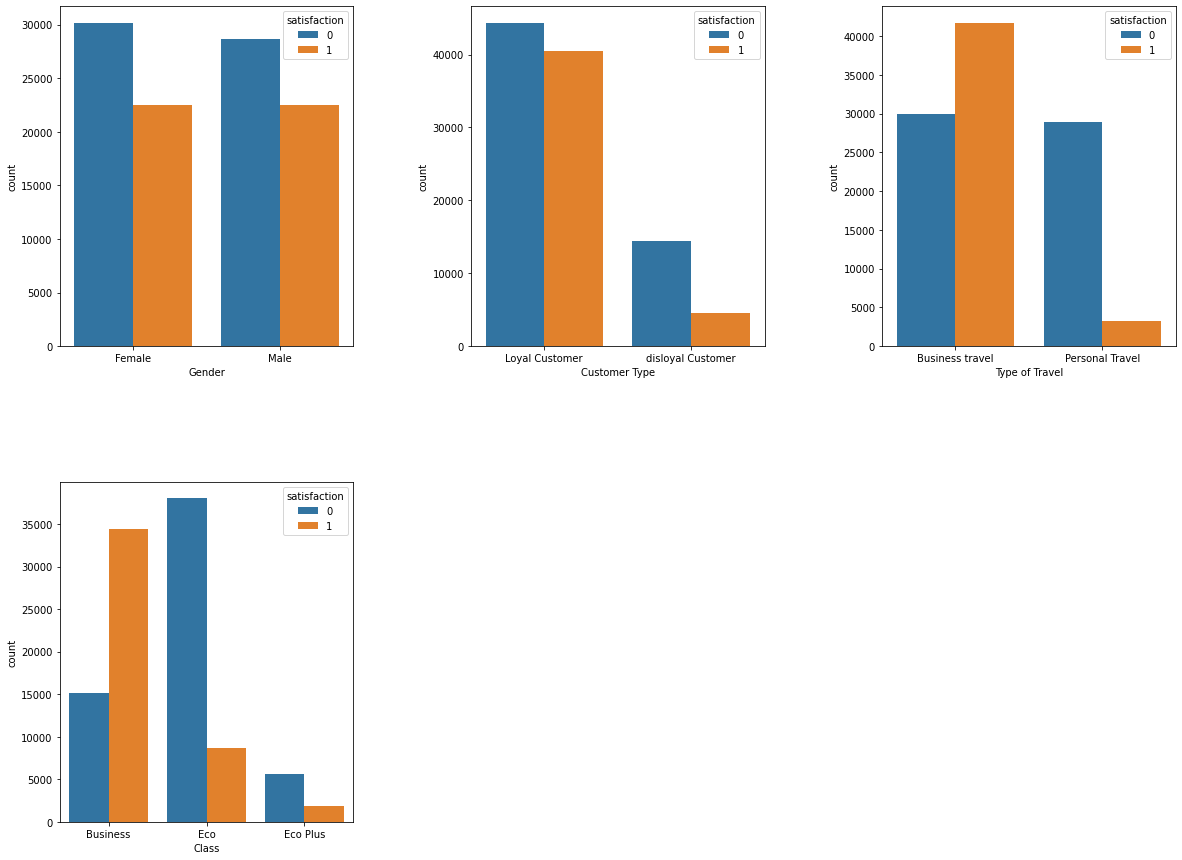

In [ ]:
plt.figure(figsize=(20, 15))
for idx, col in enumerate(train.select_dtypes(['category']).columns, 1):
    plt.subplot(2, 3, idx)
    sns.countplot(x=col, hue=TARGET_NAME, data=train)  # barplot
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# satisfied = 1

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
def cross_validation(clf, X, y):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='f1', n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def plot_cm_val(y_true, y_pred, X, y, estimator):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    conf_df = pd.DataFrame(cm, index=[0,1], columns=[0,1])
    scores = np.array(cross_validation(estimator, X, y))
    print('\n')
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    sns.heatmap(conf_df, cmap="Oranges", annot=True, annot_kws={"size": 16}, fmt='d')
    plt.title('Confusion matrix for test')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.subplot(122)
    plt.plot(scores, c='g', linestyle=':', label='Cross Validation Scores', marker='*')
    plt.fill_between(np.arange(scores.shape[0]), scores.mean() - scores.std(), scores.mean() + scores.std(), alpha=0.3)
    plt.axhline(0.5, c='r', linestyle='--', label='min f1_score')
    plt.axhline(scores.mean(), c='b', linestyle='-.', label='score mean')
    plt.legend(loc='best')
    plt.ylim([0.47, max(scores) + 0.1])
    plt.xticks(np.arange(scores.shape[0]))
    plt.grid()
    plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    roc_train, roc_test = roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)
    print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}') # weighted?
    print(f'Train GINI: {(2 * roc_train - 1):.3f}, Test GINI: {(2 * roc_test - 1):.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote


In [ ]:
# compare with dropped and not outliers, try MinMaxScaler, RobustScaler
# base: factorize, fillna median
# with predicted nans, other raw
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
for scaler in [MinMaxScaler(), StandardScaler(), RobustScaler()]:
    base = make_pipeline(scaler, LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced'))
    base.fit(X_train, y_train)
    preds_train = base.predict(X_train)
    preds_test = base.predict(X_test)
    report(y_train, preds_train, y_test, preds_test)
# no difference

Train
               precision    recall  f1-score   support

           0      0.889     0.878     0.883     41215
           1      0.843     0.857     0.850     31517

    accuracy                          0.869     72732
   macro avg      0.866     0.867     0.867     72732
weighted avg      0.869     0.869     0.869     72732

Test
               precision    recall  f1-score   support

           0      0.890     0.881     0.886     17664
           1      0.847     0.858     0.852     13508

    accuracy                          0.871     31172
   macro avg      0.868     0.869     0.869     31172
weighted avg      0.871     0.871     0.871     31172

Train ROC_AUC: 0.867, Test ROC_AUC: 0.869
Train GINI: 0.735, Test GINI: 0.739
Confusion Matrix 
 col_0             0      1
satisfaction              
0             15567   2097
1              1923  11585
Train
               precision    recall  f1-score   support

           0      0.889     0.878     0.883     41215
           1

In [ ]:
# RAW data same as with prediction
train['Arrival Delay in Minutes'].fillna(train['Arrival Delay in Minutes'].median(), inplace=True)
test['Arrival Delay in Minutes'].fillna(train['Arrival Delay in Minutes'].median(), inplace=True)
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
for scaler in [MinMaxScaler(), StandardScaler(), RobustScaler()]:
    base = make_pipeline(scaler, LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced'))
    base.fit(X_train, y_train)
    preds_train = base.predict(X_train)
    preds_test = base.predict(X_test)
    report(y_train, preds_train, y_test, preds_test)
    ts = base.predict(test.drop(TARGET_NAME,axis=1))
    print(classification_report(test[TARGET_NAME], ts))

Train
               precision    recall  f1-score   support

           0      0.889     0.878     0.883     41215
           1      0.843     0.857     0.850     31517

    accuracy                          0.869     72732
   macro avg      0.866     0.867     0.867     72732
weighted avg      0.869     0.869     0.869     72732

Test
               precision    recall  f1-score   support

           0      0.890     0.881     0.886     17664
           1      0.847     0.858     0.852     13508

    accuracy                          0.871     31172
   macro avg      0.868     0.869     0.869     31172
weighted avg      0.871     0.871     0.871     31172

Train ROC_AUC: 0.867, Test ROC_AUC: 0.869
Train GINI: 0.735, Test GINI: 0.739
Confusion Matrix 
 col_0             0      1
satisfaction              
0             15567   2097
1              1923  11585
              precision    recall  f1-score   support

           0       0.34      0.49      0.40     11403
           1       

In [ ]:
train.dropna(axis=0, inplace=True)
to_drop_idx = train.loc[train['Arrival Delay in Minutes'] > 919, :].index
train.drop(axis=0, index=to_drop_idx, inplace=True)

In [ ]:
# with dropped outliers and nans
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
for scaler in [MinMaxScaler(), StandardScaler(), RobustScaler()]:
    base = make_pipeline(scaler, LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced'))
    base.fit(X_train, y_train)
    preds_train = base.predict(X_train)
    preds_test = base.predict(X_test)
    report(y_train, preds_train, y_test, preds_test)

Train
               precision    recall  f1-score   support

           0      0.891     0.878     0.884     41085
           1      0.844     0.859     0.851     31425

    accuracy                          0.870     72510
   macro avg      0.867     0.869     0.868     72510
weighted avg      0.870     0.870     0.870     72510

Test
               precision    recall  f1-score   support

           0      0.887     0.878     0.883     17608
           1      0.843     0.854     0.848     13469

    accuracy                          0.868     31077
   macro avg      0.865     0.866     0.865     31077
weighted avg      0.868     0.868     0.868     31077

Train ROC_AUC: 0.869, Test ROC_AUC: 0.866
Train GINI: 0.737, Test GINI: 0.732
Confusion Matrix 
 col_0             0      1
satisfaction              
0             15461   2147
1              1968  11501
Train
               precision    recall  f1-score   support

           0      0.891     0.878     0.884     41085
           1

In [ ]:
train.drop(['Arrival Delay in Minutes'], axis=1, inplace=True) # after catboost and encoding

In [ ]:
# with dummies after catboost prediction - best
for column in train.select_dtypes(['uint8', 'int']).columns[:-1]:  # select_dtypes(include='numeric')
    train[column] = train[column].astype('category')
train = pd.get_dummies(train, drop_first=True, columns=train.select_dtypes('category').columns.to_list())

In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
for scaler in [MinMaxScaler(), StandardScaler(), RobustScaler()]:
    base = make_pipeline(scaler, LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced'))
    base.fit(X_train, y_train)
    preds_train = base.predict(X_train)
    preds_test = base.predict(X_test)
    report(y_train, preds_train, y_test, preds_test)

Train
               precision    recall  f1-score   support

           0      0.943     0.938     0.941     41215
           1      0.920     0.926     0.923     31517

    accuracy                          0.933     72732
   macro avg      0.932     0.932     0.932     72732
weighted avg      0.933     0.933     0.933     72732

Test
               precision    recall  f1-score   support

           0      0.941     0.940     0.941     17664
           1      0.922     0.923     0.923     13508

    accuracy                          0.933     31172
   macro avg      0.932     0.932     0.932     31172
weighted avg      0.933     0.933     0.933     31172

Train ROC_AUC: 0.932, Test ROC_AUC: 0.932
Train GINI: 0.864, Test GINI: 0.864
Confusion Matrix 
 col_0             0      1
satisfaction              
0             16612   1052
1              1037  12471
Train
               precision    recall  f1-score   support

           0      0.943     0.938     0.941     41215
           1

In [ ]:
train['Diff'] = np.abs(train['Arrival Delay in Minutes'] - train['Departure Delay in Minutes']).astype(np.float)

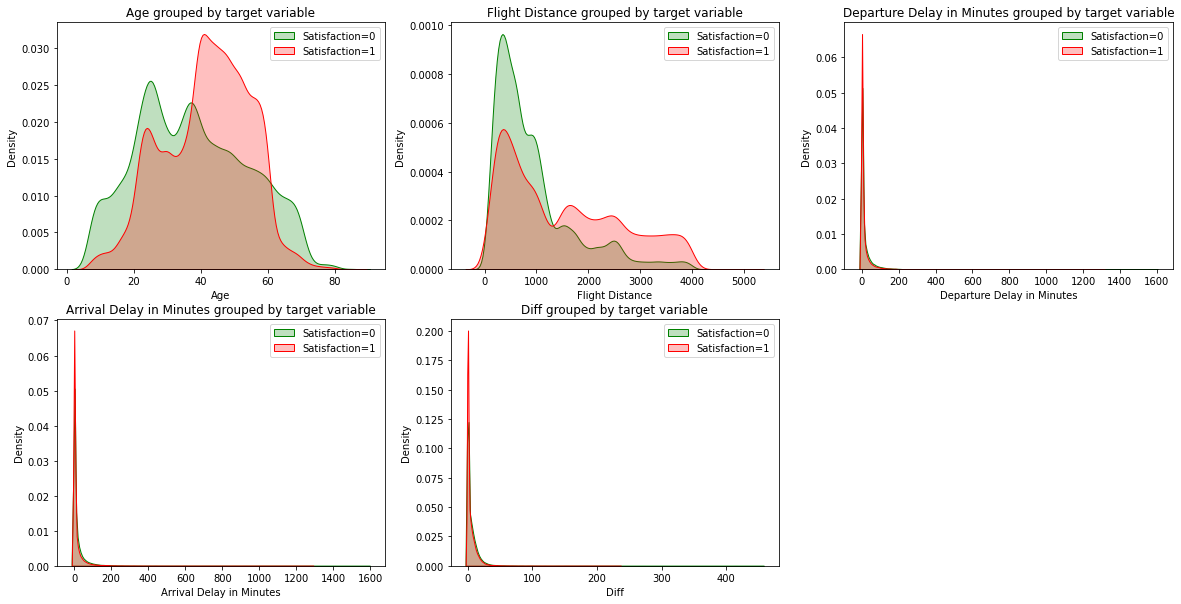

In [ ]:
plt.figure(figsize=(20, 10))
numeric_cols = train.select_dtypes(['float']).columns
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, idx)
    feature_with_target_s = train[[col, TARGET_NAME]]
    feature_s = feature_with_target_s[col]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]

    sns.kdeplot(feature_target_0, shade=True, label='Satisfaction=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Satisfaction=1', color='r')
    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.legend(loc='best')
plt.show()

In [ ]:
# as if features have not normal distribution
for idx, column in enumerate(numeric_cols, 1):
    feature_with_target_s = train[[column, TARGET_NAME]] 
    feature_s = feature_with_target_s[column]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]
    mw = mannwhitneyu(feature_target_0, feature_target_1)
    imp = np.where(mw.pvalue < 0.05, 'usefull', 'useless') 
    if imp == 'usefull' and shapiro(feature_s.dropna())[1] < 0.05:  
        print(f'{idx}) {column}, p-value: {mw.pvalue}, feature is {imp}')
    else:
        print('='*45)

1) Age, p-value: 0.0, feature is usefull
2) Flight Distance, p-value: 0.0, feature is usefull
3) Departure Delay in Minutes, p-value: 1.5767980308978006e-106, feature is usefull
4) Arrival Delay in Minutes, p-value: 8.967745016170534e-223, feature is usefull
5) Diff, p-value: 3.4689133464239733e-125, feature is usefull


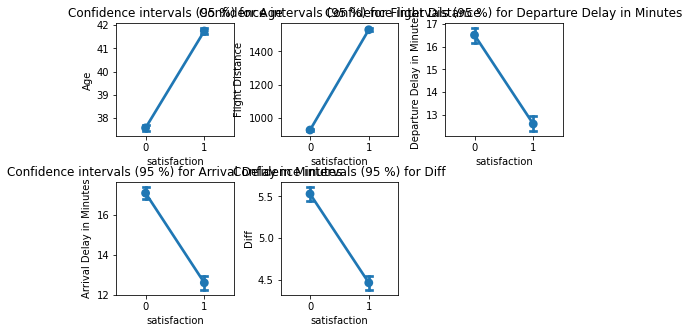

In [ ]:
plt.figure(figsize=(8, 5))
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, idx)
    to_plot = train[[col, TARGET_NAME]]
    sns.pointplot(x=TARGET_NAME, y=col, data=to_plot, capsize=.1)
    plt.title(f'Confidence intervals (95 %) for {col}')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [ ]:
shapiro(np.abs(train['Arrival Delay in Minutes'] - train['Departure Delay in Minutes']))

(0.5407379865646362, 0.0)

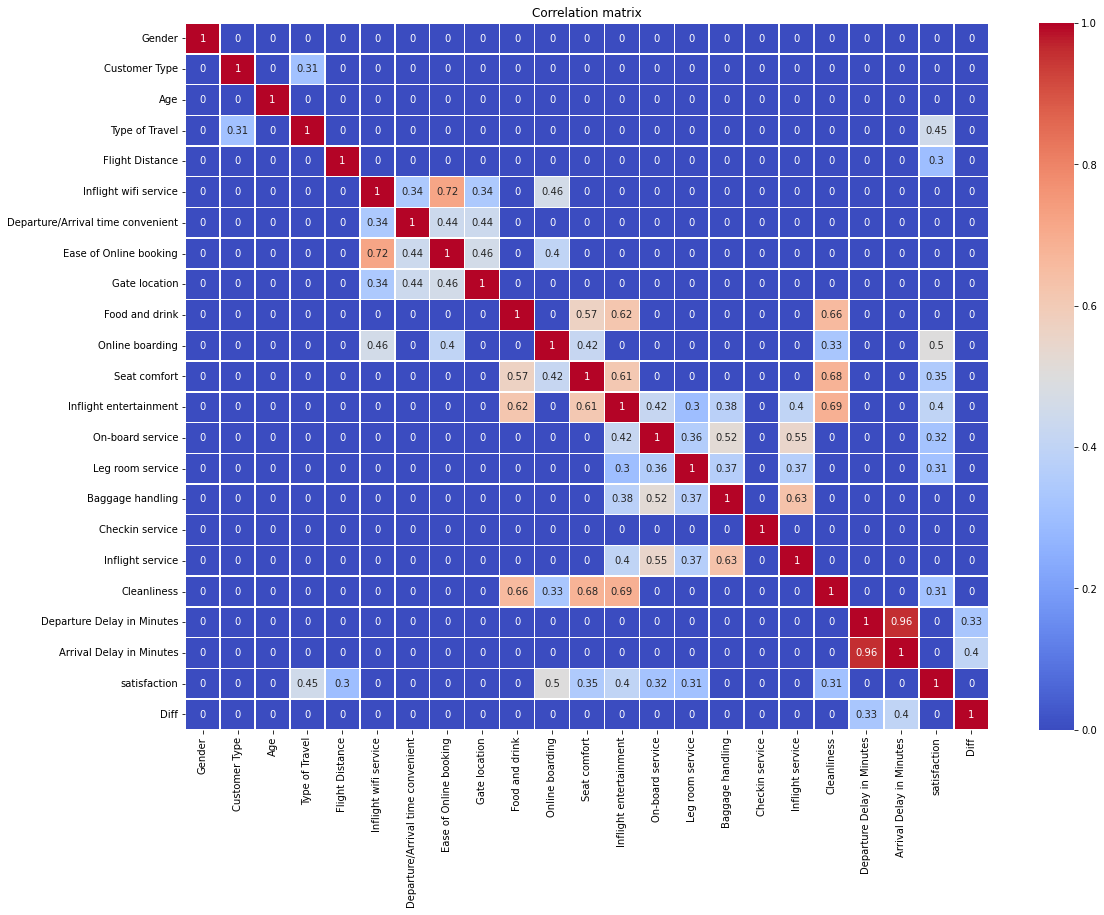

In [ ]:
# correlation matrix: choose ones that mostly correlated to target and discard mostly correlated with each other
plt.figure(figsize = (18,13))
corr_matrix = train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [ ]:
distortions, silhuettes = [], []
max_k = 10
X = train.drop(TARGET_NAME, axis=1)
for i in range(1, max_k + 1):
    if len(X) >= i:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=1, tol=1e-04)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
        if i == 1:
            continue
        #silhuettes.append(silhouette_score(X, kmeans.predict(X), random_state=1))
k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))

fig, ax = plt.subplots()
ax.plot(range(1, 11), distortions)
ax.axvline(k, ls='--', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
plt.legend(loc='best')
plt.show()

In [ ]:
# preprocessor 
  # + set_index user_id
  # + catboost prediction of nans, method with train/eval param
  # + binary and woe encoding after catboost prediction

  # + clusters kmeans
  # + np.abs(Arrival - Departure) and drop Arrival as it is highly correlated with Departure and was predicted
  # + get_dummies for category and int, not for catboost
  # + autoencoder reduction @staticmethod: input: idx of columns
# + learning curve
# + base
# + feature selection, see first block for methods to apply: correlation before dummies if to make or drop features
# lightgbm with callback lr
# calibration proba
# catboost self one-hot
# predict_proba column

In [ ]:
class AutoEncoder(Model): # vanilla autoencoder
    def __init__(self, output_units, reduce_units):
        super().__init__()
        self.encoder = Sequential([
                                   Dense(32, activation='relu'),
                                   Dense(16, activation='relu'),
                                   Dense(reduce_units, activation='relu')
        ])
        self.decoder = Sequential([
                                   Dense(16, activation='relu'),
                                   Dense(32, activation='relu'),
                                   Dense(output_units, activation='sigmoid')
        ])
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class Preprocessor:
    def __init__(self, target=TARGET_NAME, with_cat=False, cluster=7):
        self.target = target
        self.with_cat = with_cat
        self.vocab = {}
        self.params = {
                        'eval_metric': 'R2',
                        'silent': True,
                        'one_hot_max_size': 5,
                        'early_stopping_rounds': 10,
                        'boosting_type': 'Ordered',
                        'allow_writing_files': False,
                        'random_seed': 1
                       }
        self.regressor = CatBoostRegressor(**self.params, depth=7, iterations=400, learning_rate=0.3, 
                                           l2_leaf_reg=2.5, bagging_temperature=1., subsample=.9)
        self.temp = None
        self.kmeans = KMeans(n_clusters=cluster, init='k-means++', n_init=10, max_iter=300, random_state=1, tol=1e-04)
        self.label_encoders = []

    def _predict_arrival(self, df, evaluate=True):
        df['isnan'] = 0
        df.loc[~df['Arrival Delay in Minutes'].isna(), 'isnan'] = 1
        if not evaluate:
            self.temp = df.groupby(['Gender', 'Class', 'Age'])['Arrival Delay in Minutes'].mean().reset_index()
            self.temp = self.temp.rename(columns={'Arrival Delay in Minutes': 'temp'})
        df = df.merge(self.temp, on=['Gender', 'Class', 'Age'], how='left')
        df.Age = df.Age.astype(np.float)
        df['Departure Delay in Minutes'] = df['Departure Delay in Minutes'].astype(float)
        df['Flight Distance'] = df['Flight Distance'].astype(np.float)
        for col in df.select_dtypes('object').columns:
            df[col] = df[col].astype('category')
        if not evaluate:
            cat_cols = df.select_dtypes(['category', 'int']).columns[:-1].to_list()
            X = df[df.isnan == 1].drop([self.target, 'Arrival Delay in Minutes', 'isnan'], axis=1)
            y = df[df.isnan == 1]['Arrival Delay in Minutes']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            test_pool = Pool(X_test, y_test, cat_features=cat_cols)
            self.regressor.fit(train_pool, eval_set=test_pool, use_best_model=True)
            preds_train = self.regressor.predict(X_train)
            preds_test = self.regressor.predict(X_test)
            print(f'train MSE: {mean_squared_error(y_train, preds_train)}, train MAE: {mean_absolute_error(y_train, preds_train)}',
                  f'train R^2: {r2_score(y_train, preds_train)}')
            print(f'test MSE: {mean_squared_error(y_test, preds_test)}, test MAE: {mean_absolute_error(y_test, preds_test)}',
                  f'test R^2: {r2_score(y_test, preds_test)}')
        if not evaluate:
            df.loc[df.isnan == 0, 'Arrival Delay in Minutes'] = self.regressor.predict(df.drop([self.target, 
                                                                                    'Arrival Delay in Minutes', 'isnan'],
                                                                                    axis=1).loc[df.isnan == 0, :])
        else:
            df.loc[df.isnan == 0, 'Arrival Delay in Minutes'] = self.regressor.predict(df.drop(['Arrival Delay in Minutes', 
                                                                                                'isnan'], axis=1).loc[df.isnan == 0, :])
        df.drop(['isnan', 'temp'], axis=1, inplace=True)
        return df

    def fit(self, df):
        return df

    def _encode_woe(self, df):
        emb_count_0 = df.loc[df[self.target] == 0, 'Class'].count()
        emb_count_1 = df.loc[df[self.target] == 1, 'Class'].count()
        for item in df.Class.unique():
            percent_non_event = df.loc[((df[self.target] == 0) & (df.Class == item)), 'Class'].count() / emb_count_0
            percent_event = df.loc[((df[self.target] == 1) & (df.Class == item)), 'Class'].count() / emb_count_1
            self.vocab[item] = np.log(percent_non_event / percent_event)

    def transform(self, df):
        df.set_index('id', drop=True, inplace=True)
        if self.target in df.columns:
            df[self.target] = df[self.target].map({'satisfied': 0, 'neutral or dissatisfied': 1}).astype(np.uint8) # factorize()[0]
        # 'Gate location_0', 'Seat comfort_0', 'Checkin service_0'
        df.loc[df['Gate location'] == 0, 'Gate location'] = 1
        df.loc[df['Seat comfort'] == 0, 'Seat comfort'] = 1
        df.loc[df['Checkin service'] == 0, 'Checkin service'] = 1
        evaluate = False if self.target in df.columns else True
        df = self._predict_arrival(df, evaluate=evaluate)
        if not self.with_cat:
            if self.target in df.columns:
                for column in df.select_dtypes(['category']).columns:
                    if len(df[column].unique()) < 3:
                        label = LabelEncoder()
                        df[column] = label.fit_transform(df[column])
                        self.label_encoders.append(label)
            else:
                i = 0
                for column in df.select_dtypes(['category']).columns:
                    if len(df[column].unique()) < 3:
                        df[column] = self.label_encoders[i].transform(df[column])
                        i += 1
                    # df[column] = df[column].factorize()[0].astype(np.uint8)
            if self.target in df.columns:
                self._encode_woe(df)
            df.Class = df.Class.map(self.vocab)
        return df
    
    def create_features(self, df):
        df['Diff'] = np.abs(df['Arrival Delay in Minutes'] - df['Departure Delay in Minutes']).astype(np.float32)
        df.drop('Arrival Delay in Minutes', axis=1, inplace=True)

        if not self.with_cat:
            if self.target in df.columns:
                self.kmeans.fit(df.drop(self.target, axis=1))
                df['Cluster'] = self.kmeans.predict(df.drop(self.target, axis=1)).astype(np.uint8)
            else:
                df['Cluster'] = self.kmeans.predict(df).astype(np.uint8)
            for column in df.select_dtypes(['uint8', 'int8']).columns:
                if column != self.target:
                    df[column] = df[column].astype('category')
            df = pd.get_dummies(df, drop_first=False, columns=df.select_dtypes('category').columns.to_list())
        #if self.target not in df.columns:
            # 'Gate location_0', 'Seat comfort_0', 'Checkin service_0'
        #    df['Gate location_0'], df['Seat comfort_0'], df['Checkin service_0'] = 0, 0, 0
        #    df['Gate location_0'], df['Seat comfort_0'], df['Checkin service_0'] = df['Gate location_0'].astype('category'), df['Seat comfort_0'].astype('category'), df['Checkin service_0'].astype('category')
        return df

    def __call__(self, df):
        if self.target in df.columns:
            df = self.fit(df)
        df = self.transform(df)
        df = self.reduce_memory(df)
        df = self.create_features(df)
        df = df.sample(frac=1)
        return df
    
    @staticmethod
    def reduce_dim(df, indices, size=40):
        X = df.values[:, indices]
        columns_to_drop = list(np.array(df.columns)[indices])
        X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True, random_state=1)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)        
        enc = AutoEncoder(X.shape[1], size)
        enc.compile(loss='mae', metrics=['mae'], optimizer=tf.keras.optimizers.Adam(lr=1e-3))
        history = enc.fit(X_train_scaled, X_train_scaled, epochs=15, batch_size=128, 
                          validation_data=(X_test_scaled, X_test_scaled), 
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto'),
                                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)])
        encoder_layer = enc.encoder # enc.get_layer('sequential')
        reduced_df = pd.DataFrame(encoder_layer.predict(X))
        reduced_df = reduced_df.add_prefix('feature_')
        df.drop(columns_to_drop, axis=1, inplace=True)
        return pd.concat([df, reduced_df], axis=1)

    @staticmethod
    def reduce_memory(df):
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            elif str(col_type)[:4] != 'uint':
                df[col] = df[col].astype('category')
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        return df

In [ ]:
train = pd.read_csv(train_root, index_col=0)
test = pd.read_csv(test_root, index_col=0)
train = pd.concat([train, test], axis=0)
train = train.sample(frac=1)
#test, y_targets = test.drop(TARGET_NAME, axis=1), test[TARGET_NAME].map({'satisfied': 0, 'neutral or dissatisfied': 1})
preprocessor = Preprocessor(with_cat=False, cluster=2)
train = preprocessor(train)
#test = preprocessor(test)

train MSE: 93.63937987344525, train MAE: 5.433306735781384 train R^2: 0.9354071886526887
test MSE: 113.78852165102874, test MAE: 5.451200990041601 test R^2: 0.9288440864734944
Memory usage of dataframe is 22.05 MB
Memory usage after optimization is: 5.33 MB
Decreased by 75.8%


In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

Train
               precision    recall  f1-score   support

           0      0.920     0.927     0.924     39500
           1      0.944     0.938     0.941     51416

    accuracy                          0.933     90916
   macro avg      0.932     0.933     0.932     90916
weighted avg      0.933     0.933     0.933     90916

Test
               precision    recall  f1-score   support

           0      0.920     0.926     0.923     16928
           1      0.943     0.938     0.940     22036

    accuracy                          0.933     38964
   macro avg      0.931     0.932     0.931     38964
weighted avg      0.933     0.933     0.933     38964

Train ROC_AUC: 0.933, Test ROC_AUC: 0.932
Train GINI: 0.865, Test GINI: 0.864
Confusion Matrix 
 col_0             0      1
satisfaction              
0             15668   1260
1              1366  20670
Меры правильности перекрекстной оценки: [0.93993207 0.94235638 0.94257812 0.93895888 0.94030288 0.94349566
 0.93897446 0.9404076

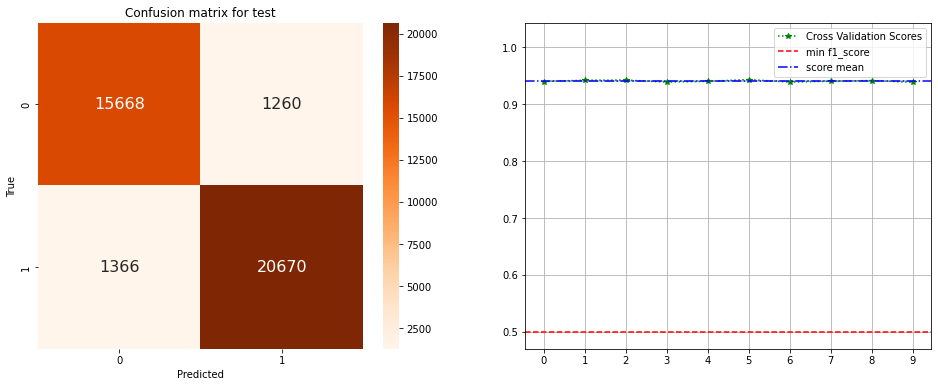

In [ ]:
#base = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1.0, tol=1e-3, 
#                     max_iter=200, class_weight='balanced'))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
base = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1.0, tol=1e-3, max_iter=200, 
                          class_weight='balanced')
base.fit(X_train, y_train)
preds_train = base.predict(X_train)
preds_test = base.predict(X_test)
report(y_train, preds_train, y_test, preds_test)
plot_cm_val(y_test, preds_test, X_train, y_train, base)

In [ ]:
#final = base.predict(scaler.transform(test))
#print(classification_report(y_targets, final))

              precision    recall  f1-score   support

           0       0.44      0.44      0.44     11403
           1       0.56      0.56      0.56     14573

    accuracy                           0.51     25976
   macro avg       0.50      0.50      0.50     25976
weighted avg       0.51      0.51      0.51     25976



In [ ]:
indices = np.arange(10,79)
train = preprocessor.reduce_dim(train, indices)
# in this case does not make sense as reducing columns all contain from 0 and 1

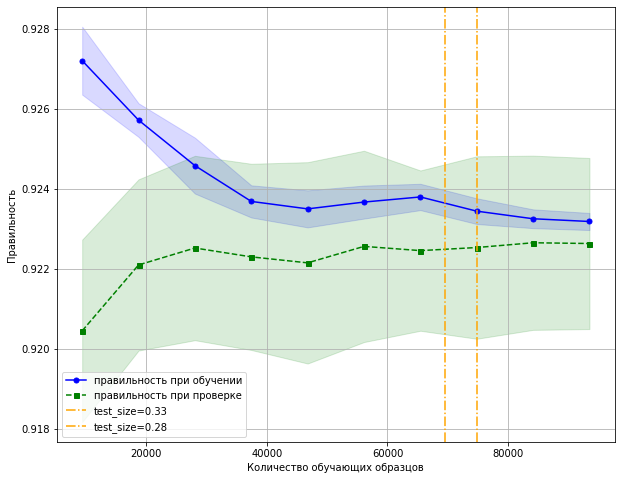

In [ ]:
estimator = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                        max_iter=200, class_weight='balanced'))
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='f1', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X.shape[0]*0.72, color='orange', linestyle='-.', label='test_size=0.28')
#plt.annotate('Best split point', (X.shape[0]*0.7, train_mean))
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# оптимальный test_size=0.3

In [ ]:
# lightGBM, callbacks, try eval metric - logloss, depth 8 estimators - 25: get .99 f1 / SHAP!

In [ ]:
train[TARGET_NAME].value_counts(normalize=True)
import math

Train
               precision    recall  f1-score   support

           0      0.989     0.950     0.969     39500
           1      0.963     0.992     0.977     51416

    accuracy                          0.974     90916
   macro avg      0.976     0.971     0.973     90916
weighted avg      0.974     0.974     0.974     90916

Test
               precision    recall  f1-score   support

           0      0.981     0.938     0.959     16928
           1      0.954     0.986     0.970     22036

    accuracy                          0.965     38964
   macro avg      0.967     0.962     0.964     38964
weighted avg      0.966     0.965     0.965     38964

Train ROC_AUC: 0.971, Test ROC_AUC: 0.962
Train GINI: 0.942, Test GINI: 0.924
Confusion Matrix 
 col_0             0      1
satisfaction              
0             15886   1042
1               314  21722
Меры правильности перекрекстной оценки: [0.96417625 0.96485011 0.96947005 0.96653846 0.96534511 0.96747034
 0.94337109 0.9672225

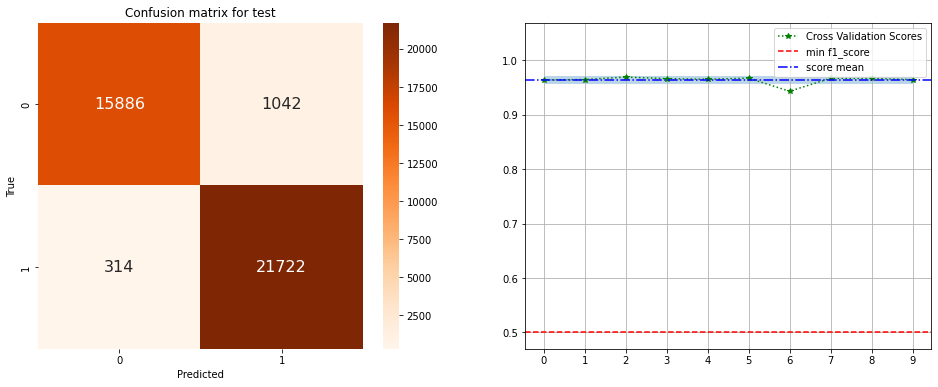

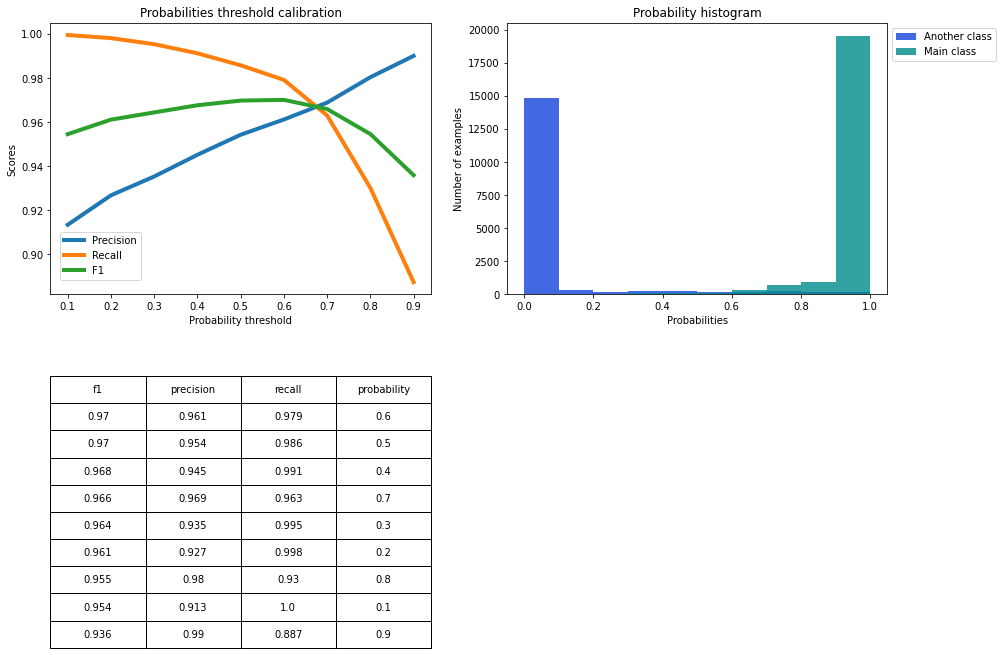

In [ ]:
alpha, k = 0.08, 1e-2
# add tunning with sklearn ParamGrid
lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=61, max_depth=8, learning_rate=0.3, n_estimators=150,
                      subsample=.3, colsample_bytree=.9, reg_lambda=1e-5, reg_alpha=1e-4, n_jobs=-1, silent=True, 
                      scale_pos_weight=1.4, random_state=1)
lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=5, 
         callbacks=[lightgbm.reset_parameter(learning_rate=lambda current_round: alpha * np.exp(k * current_round))],
         eval_metric='logloss')
l_train_pred = lgbm.predict(X_train)
l_test_pred = lgbm.predict(X_test)
report(y_train, l_train_pred, y_test, l_test_pred)
plot_cm_val(y_test, l_test_pred, X_train, y_train, lgbm)
show_proba_calibration_plots(lgbm.predict_proba(X_test)[:, 1], y_test)

In [ ]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap_values_test = explainer.shap_values(X_test)

In [ ]:
probas = lgbm.predict_proba(X_test)[:, 1]
high_idx = np.argsort(probas)[::-1][0]

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][high_idx,:], X_test.iloc[high_idx,:])

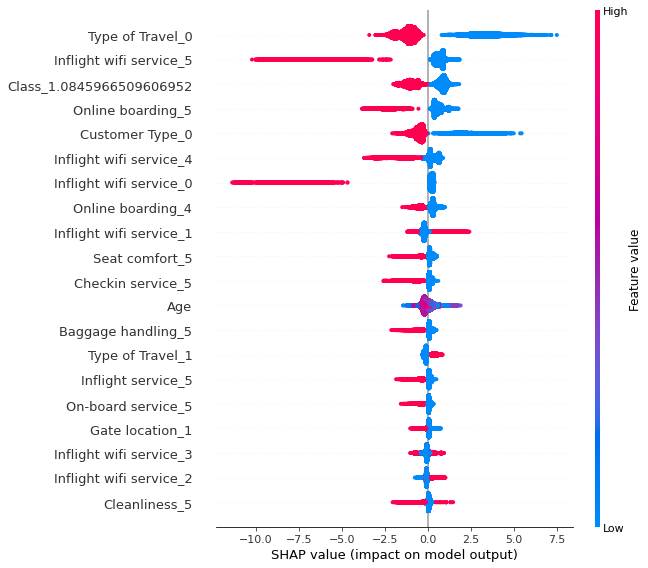

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_test[1], features=X_test, feature_names=X.columns)

In [ ]:
X_test.iloc[high_idx, :], probas[high_idx]

(Age                              9.0
 Flight Distance               1005.0
 Departure Delay in Minutes     100.0
 Diff                            24.0
 Gender_0                         0.0
                                ...  
 Cleanliness_3                    0.0
 Cleanliness_4                    1.0
 Cleanliness_5                    0.0
 Cluster_0                        1.0
 Cluster_1                        0.0
 Name: 16995, Length: 95, dtype: float32, 0.9999927300259478)

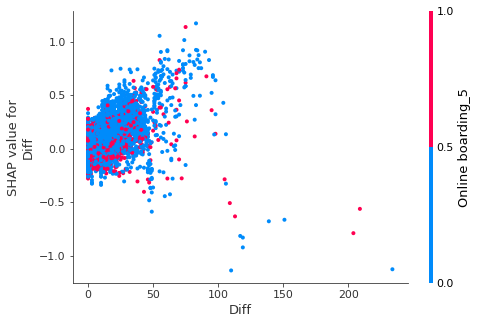

In [ ]:
shap.initjs()
shap.dependence_plot('Diff', shap_values_test[1], X_test, display_features=X_test)

In [ ]:
# catboost

In [ ]:
train = pd.read_csv(train_root, index_col=0)
test = pd.read_csv(test_root, index_col=0)
train = pd.concat([train, test], axis=0)
train = train.sample(frac=1)
preprocessor = Preprocessor(with_cat=True, cluster=2)
train = preprocessor(train)
#test = preprocessor(test)

train MSE: 109.76591780603373, train MAE: 5.850948140599468 train R^2: 0.9247433490823131
test MSE: 102.75242918087618, test MAE: 5.8282648420486085 test R^2: 0.9342894607166594
Memory usage of dataframe is 19.45 MB
Memory usage after optimization is: 5.33 MB
Decreased by 72.6%


In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

In [ ]:
cat_cols = [columns for columns in X.select_dtypes(['category', 'int8']).columns]
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols) 
params_model = {
    'eval_metric': 'F1',
    'loss_function': 'Logloss',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 5,
    'early_stopping_rounds': 10,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,
    'random_seed': 1
}

In [ ]:
catboost = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [5, 6, 7, 8],
    'learning_rate': [0.03, 0.1, 0.3, 0.01],
    'iterations': [100, 200],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=20, shuffle=True, stratified=True, 
                                 partition_random_seed=1, cv=5)

Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9283850341
bestIteration = 33

0:	loss: 0.9283850	best: 0.9283850 (0)	total: 6.77s	remaining: 2m 8s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9575439384
bestIteration = 114

1:	loss: 0.9575439	best: 0.9575439 (1)	total: 28.9s	remaining: 4m 19s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9530380719
bestIteration = 110

2:	loss: 0.9530381	best: 0.9575439 (1)	total: 56.7s	remaining: 5m 21s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9476419581
bestIteration = 61

3:	loss: 0.9476420	best: 0.9575439 (1)	total: 1m 14s	remaining: 4m 58s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9581349808
bestIteration = 83

4:	loss: 0.9581350	best: 0.9581350 (4)	total: 1m 27s	remaining: 4m 22s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9615029248
bestIteration = 55

5:	loss: 0.9615029	best: 0.9615029 (5)	total: 1m 50s	

In [ ]:
gs['params']

{'bagging_temperature': 1,
 'depth': 8,
 'iterations': 200,
 'l2_leaf_reg': 2.5,
 'learning_rate': 0.3,
 'subsample': 0.7}

In [ ]:
alpha, k = 0.05, 1e-2
catboost = CatBoostClassifier(**params_model, depth=8, iterations=200, learning_rate=0.3, l2_leaf_reg=2.5,
                              bagging_temperature=1., subsample=0.7)
catboost.fit(train_pool, eval_set=test_pool) #, callbacks=[lambda current_round: alpha * np.exp(k * current_round)])
cat_train_pred = catboost.predict(X_train)
cat_test_pred = catboost.predict(X_test)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Train
               precision    recall  f1-score   support

           0      0.967     0.953     0.960     39500
           1      0.964     0.975     0.970     51416

    accuracy                          0.965     90916
   macro avg      0.966     0.964     0.965     90916
weighted avg      0.965     0.965     0.965     90916

Test
               precision    recall  f1-score   support

           0      0.965     0.949     0.957     16928
           1      0.961     0.973     0.967     22036

    accuracy                          0.963     38964
   macro avg      0.963     0.961     0.962     38964
weighted avg      0.963     0.963     0.963     38964

Train ROC_AUC: 0.964, Test ROC_AUC: 0.961
Train GINI: 0.928, Test GINI: 0.923
Confusion Matrix 
 col_0             0      1
satisfaction              
0             16066    862
1               584  21452


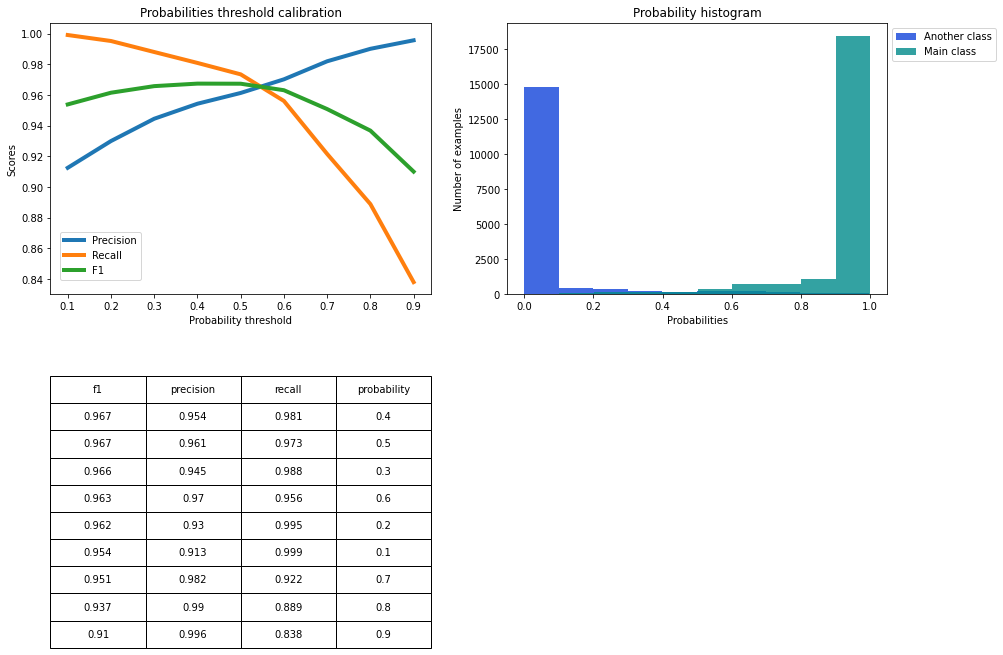

In [ ]:
report(y_train, cat_train_pred, y_test, cat_test_pred)
show_proba_calibration_plots(catboost.predict_proba(X_test)[:, 1], y_test)

In [ ]:
# try default from box
cat = CatBoostClassifier()
cat.fit(train_pool, eval_set=test_pool)
cat_train = cat.predict(X_train)
cat_test = cat.predict(X_test)

Learning rate set to 0.096537
0:	learn: 0.5591296	test: 0.5591221	best: 0.5591221 (0)	total: 354ms	remaining: 5m 53s
1:	learn: 0.4471810	test: 0.4464567	best: 0.4464567 (1)	total: 548ms	remaining: 4m 33s
2:	learn: 0.3640333	test: 0.3630940	best: 0.3630940 (2)	total: 864ms	remaining: 4m 47s
3:	learn: 0.3081534	test: 0.3071877	best: 0.3071877 (3)	total: 1.08s	remaining: 4m 29s
4:	learn: 0.2708936	test: 0.2701148	best: 0.2701148 (4)	total: 1.31s	remaining: 4m 20s
5:	learn: 0.2472319	test: 0.2464393	best: 0.2464393 (5)	total: 1.48s	remaining: 4m 5s
6:	learn: 0.2304707	test: 0.2295143	best: 0.2295143 (6)	total: 1.82s	remaining: 4m 18s
7:	learn: 0.2188278	test: 0.2179869	best: 0.2179869 (7)	total: 2.01s	remaining: 4m 9s
8:	learn: 0.2056914	test: 0.2052492	best: 0.2052492 (8)	total: 2.24s	remaining: 4m 6s
9:	learn: 0.1971213	test: 0.1966927	best: 0.1966927 (9)	total: 2.53s	remaining: 4m 10s
10:	learn: 0.1859153	test: 0.1856235	best: 0.1856235 (10)	total: 2.77s	remaining: 4m 8s
11:	learn: 0.17

In [ ]:
report(y_train, cat_train, y_test, cat_test)

Train
               precision    recall  f1-score   support

           0      0.982     0.956     0.969     39500
           1      0.967     0.987     0.977     51416

    accuracy                          0.973     90916
   macro avg      0.975     0.971     0.973     90916
weighted avg      0.974     0.973     0.973     90916

Test
               precision    recall  f1-score   support

           0      0.974     0.945     0.959     16928
           1      0.959     0.980     0.970     22036

    accuracy                          0.965     38964
   macro avg      0.966     0.963     0.964     38964
weighted avg      0.965     0.965     0.965     38964

Train ROC_AUC: 0.971, Test ROC_AUC: 0.963
Train GINI: 0.943, Test GINI: 0.926
Confusion Matrix 
 col_0             0      1
satisfaction              
0             16000    928
1               431  21605


In [ ]:
# catboost fit init_model: use pretrained model for new model

In [ ]:
from catboost import cv

In [ ]:
scores = cv(train_pool,
            params_model,
            fold_count=2,
            plot="True",)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.912603938
bestIteration = 1

Training on fold [1/2]

bestTest = 0.9569874728
bestIteration = 233



In [ ]:
scores

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.901226,0.006048,0.900438,0.006606,0.644671,0.004663,0.644663,0.004462
1,1,0.904777,0.011069,0.904408,0.012159,0.598633,0.000926,0.598612,0.000614
2,2,0.910895,0.001092,0.910809,0.000527,0.559932,0.002543,0.560468,0.002020
3,3,0.911944,0.000641,0.912412,0.002141,0.522505,0.001874,0.523005,0.002155
4,4,0.910700,0.001958,0.910915,0.002913,0.487601,0.004001,0.487945,0.004083
...,...,...,...,...,...,...,...,...,...
239,239,0.933355,0.033325,0.934503,0.031981,0.225429,0.167599,0.224606,0.168967
240,240,0.933341,0.033305,0.934511,0.031993,0.225411,0.167625,0.224585,0.168997
241,241,0.933379,0.033359,0.934589,0.032103,0.225353,0.167707,0.224526,0.169080
242,242,0.933381,0.033362,0.934579,0.032089,0.225331,0.167738,0.224486,0.169137


In [ ]:
train = pd.read_csv(train_root, index_col=0)
test = pd.read_csv(test_root, index_col=0)

In [ ]:
train.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [ ]:
# Drop columns 'Unnamed: 0', and 'id'
train.drop(['id'], axis = 1, inplace = True)
test.drop(['id'], axis = 1, inplace = True)

In [ ]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [ ]:
X_train = train.apply(LabelEncoder().fit_transform)
X_test = test.apply(LabelEncoder().fit_transform)

In [ ]:
# Replace y_train, y_test categorical data to numeric values
y_train = train['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
y_test = test['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})

In [ ]:
X_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,0,6,1,2,358,3,4,3,1,5,3,5,5,4,3,3,4,5,5,25,18,0
1,1,1,18,0,0,144,3,2,3,3,1,3,1,1,1,5,2,1,4,1,1,6,0
2,0,0,19,0,0,994,2,2,2,2,5,5,5,5,4,3,3,4,4,5,0,0,1
3,0,0,18,0,0,446,2,5,5,5,2,2,2,2,2,5,2,1,4,2,11,9,0
4,1,0,54,0,0,124,3,3,3,3,4,5,5,3,3,4,3,3,3,3,0,0,1


In [ ]:
ss = StandardScaler().fit(X_train)

lr = LogisticRegression()

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

lr.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.96      0.02      0.04     58697
           1       0.44      1.00      0.61     44897

    accuracy                           0.44    103594
   macro avg       0.70      0.51      0.32    103594
weighted avg       0.73      0.44      0.29    103594

              precision    recall  f1-score   support

           0       0.97      0.02      0.04     14528
           1       0.44      1.00      0.61     11365

    accuracy                           0.45     25893
   macro avg       0.71      0.51      0.33     25893
weighted avg       0.74      0.45      0.29     25893



In [ ]:
lr.score(X_test_scaled, y_test)

1.0

In [ ]:
f1_score(y_test, pred_test)

0.614880597823144

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103594 non-null  object 
 1   Customer Type                      103594 non-null  object 
 2   Age                                103594 non-null  int64  
 3   Type of Travel                     103594 non-null  object 
 4   Class                              103594 non-null  object 
 5   Flight Distance                    103594 non-null  int64  
 6   Inflight wifi service              103594 non-null  int64  
 7   Departure/Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking             103594 non-null  int64  
 9   Gate location                      103594 non-null  int64  
 10  Food and drink                     103594 non-null  int64  
 11  Online boarding                    1035

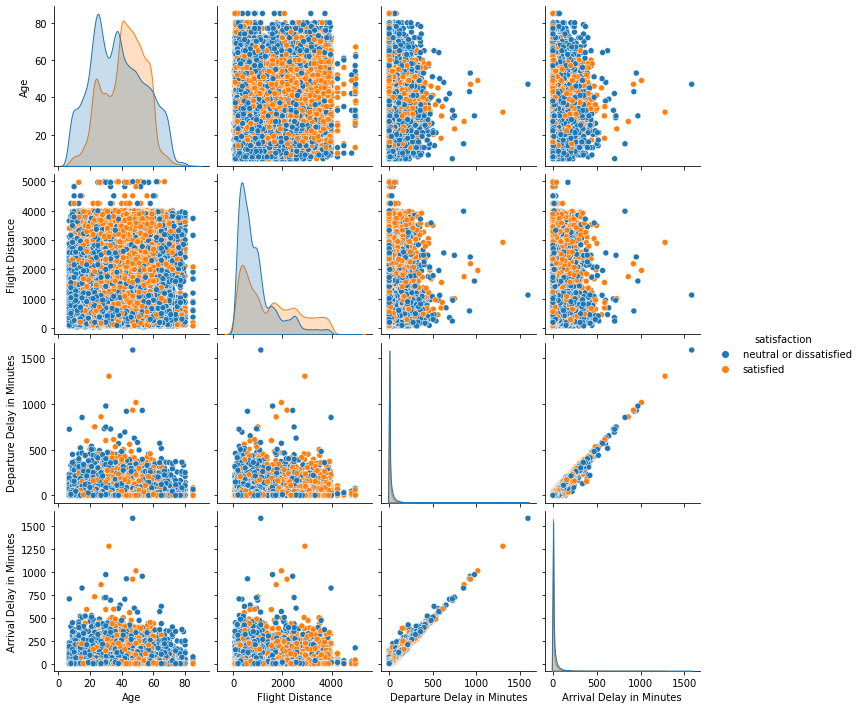

In [ ]:
non_float_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'satisfaction']
sns.pairplot(train[non_float_cols], hue=TARGET_NAME)
plt.show()

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103594 non-null  category
 1   Customer Type                      103594 non-null  category
 2   Age                                103594 non-null  float32 
 3   Type of Travel                     103594 non-null  category
 4   Class                              103594 non-null  category
 5   Flight Distance                    103594 non-null  float32 
 6   Inflight wifi service              103594 non-null  int16   
 7   Departure/Arrival time convenient  103594 non-null  int16   
 8   Ease of Online booking             103594 non-null  int16   
 9   Gate location                      103594 non-null  int16   
 10  Food and drink                     103594 non-null  int16   
 11  Online boarding           

In [ ]:
for dataset in [train, test]:
    for column in dataset.columns:
        if column != TARGET_NAME:
            if str(dataset[column].dtype) == 'object':
                dataset[column] = dataset[column].astype('category')
            elif column in non_float_cols:
                dataset[column] = dataset[column].astype(np.float32)
            else:
                dataset[column] = dataset[column].astype(np.int16)
        else:
            dataset[column] = dataset[column].map({'neutral or dissatisfied': 0, 'satisfied': 1})

In [ ]:
X, y = train.drop(TARGET_NAME, axis=1), train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

In [ ]:
cat_cols = [columns for columns in X.select_dtypes(['category', 'int8']).columns]
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols) 
params_model = {
    'eval_metric': 'F1',
    'loss_function': 'Logloss',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 5,
    'early_stopping_rounds': 10,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,
    'random_seed': 1
}

In [ ]:
cat = CatBoostClassifier()
cat.fit(train_pool, eval_set=[test_pool])

Learning rate set to 0.091292
0:	learn: 0.5445170	test: 0.5443981	best: 0.5443981 (0)	total: 101ms	remaining: 1m 41s
1:	learn: 0.4645107	test: 0.4639603	best: 0.4639603 (1)	total: 166ms	remaining: 1m 22s
2:	learn: 0.4052463	test: 0.4040288	best: 0.4040288 (2)	total: 244ms	remaining: 1m 21s
3:	learn: 0.3580814	test: 0.3571027	best: 0.3571027 (3)	total: 316ms	remaining: 1m 18s
4:	learn: 0.3055123	test: 0.3043255	best: 0.3043255 (4)	total: 380ms	remaining: 1m 15s
5:	learn: 0.2835084	test: 0.2820368	best: 0.2820368 (5)	total: 441ms	remaining: 1m 13s
6:	learn: 0.2477779	test: 0.2462857	best: 0.2462857 (6)	total: 531ms	remaining: 1m 15s
7:	learn: 0.2351340	test: 0.2334888	best: 0.2334888 (7)	total: 610ms	remaining: 1m 15s
8:	learn: 0.2187223	test: 0.2174494	best: 0.2174494 (8)	total: 688ms	remaining: 1m 15s
9:	learn: 0.2090312	test: 0.2076575	best: 0.2076575 (9)	total: 772ms	remaining: 1m 16s
10:	learn: 0.2024349	test: 0.2010886	best: 0.2010886 (10)	total: 850ms	remaining: 1m 16s
11:	learn: 

In [ ]:
cat_train = cat.predict(X_train)
cat_test = cat.predict(X_test)

In [ ]:
report(y_train, cat_train, y_test, cat_test)

Train
               precision    recall  f1-score   support

           0      0.974     0.989     0.981     41087
           1      0.985     0.965     0.975     31428

    accuracy                          0.979     72515
   macro avg      0.980     0.977     0.978     72515
weighted avg      0.979     0.979     0.979     72515

Test
               precision    recall  f1-score   support

           0      0.960     0.979     0.969     17610
           1      0.972     0.947     0.959     13469

    accuracy                          0.965     31079
   macro avg      0.966     0.963     0.964     31079
weighted avg      0.965     0.965     0.965     31079

Train ROC_AUC: 0.977, Test ROC_AUC: 0.963
Train GINI: 0.954, Test GINI: 0.925
Confusion Matrix 
 col_0             0      1
satisfaction              
0             17236    374
1               719  12750


In [ ]:
X_train = pd.get_dummies(train, columns = ["Gender", "Customer Type", "Type of Travel", "Class", 
                                          "Inflight wifi service", "Departure/Arrival time convenient", 
                                          "Ease of Online booking", "Gate location", "Food and drink", 
                                          "Online boarding", "Seat comfort", "Inflight entertainment", 
                                          "On-board service", "Leg room service", "Baggage handling", 
                                          "Checkin service", "Inflight service", "Cleanliness"])
X_test = pd.get_dummies(test, columns = ["Gender", "Customer Type", "Type of Travel", "Class", 
                                          "Inflight wifi service", "Departure/Arrival time convenient", 
                                          "Ease of Online booking", "Gate location", "Food and drink", 
                                          "Online boarding", "Seat comfort", "Inflight entertainment", 
                                          "On-board service", "Leg room service", "Baggage handling", 
                                          "Checkin service", "Inflight service", "Cleanliness"])

In [ ]:
X_train.columns.difference(X_test.columns)

Index(['Checkin service_0', 'Gate location_0', 'Seat comfort_0'], dtype='object')

In [ ]:
X_train.drop(['Checkin service_0', 'Gate location_0', 'Seat comfort_0'], axis=1, inplace=True)

In [ ]:
(X_train.columns == X_test.columns).astype(int).sum()

94

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
xgboost = XGBClassifier(n_estimators=25, max_depth=8, learning_rate=0.4, 
                        eval_metric='logloss', use_label_encoder=False, random_state=42)
xgboost.fit(X_train, train[TARGET_NAME])
pred_train = xgboost.predict(X_train)
pred_test = xgboost.predict(X_test)

In [ ]:
report(train[TARGET_NAME], pred_train, test[TARGET_NAME], pred_test)

Train
               precision    recall  f1-score   support

           0      1.000     1.000     1.000     58697
           1      1.000     1.000     1.000     44897

    accuracy                          1.000    103594
   macro avg      1.000     1.000     1.000    103594
weighted avg      1.000     1.000     1.000    103594

Test
               precision    recall  f1-score   support

           0      1.000     1.000     1.000     14528
           1      1.000     1.000     1.000     11365

    accuracy                          1.000     25893
   macro avg      1.000     1.000     1.000     25893
weighted avg      1.000     1.000     1.000     25893

Train ROC_AUC: 1.000, Test ROC_AUC: 1.000
Train GINI: 1.000, Test GINI: 1.000
Confusion Matrix 
 col_0             0      1
satisfaction              
0             14528      0
1                 0  11365


In [ ]:
"""
so we just need to:
- drop 'id' or set it ti index
- drop nans as if they are very few
- change features dtypes needed for one-hot encoding
- apply get_dummies to selected categorical columns
- train gradient-boosting model with good params (got by grid search)
Get perfect result
"""